coggers is my favorite song from interstellar, let's see what it looks like

In [1]:
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [2]:
sample_rate, coggers = wav.read('data/hans_zimmer/coggers.wav')

In [3]:
length = len(coggers)

length, sample_rate

(10590336, 44100)

In [4]:
# song length: 240 seconds

length/240 # approximately the sample rate

44126.4

In [5]:
# split the data into two tracks for separate training

a = coggers[:,0]
b = coggers[:,1]

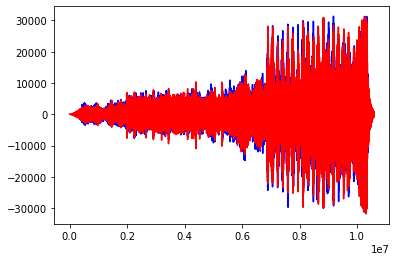

In [6]:
plt.plot(a, 'b')
plt.plot(b, 'r')

In [7]:
for i,(j,k) in enumerate(zip(a,b)):
    if j > 0 or k > 0:
        print(i)
        break

16482


In [8]:
# first 16482 numbers are all 0s
# that is 0.37 seconds, negligible enough

16482 / sample_rate 

0.3737414965986395

In [9]:
# HYPERPARAMETERS

SEQ_LEN = 5 # this is in seconds
SEQ_LEN = SEQ_LEN * sample_rate
print(SEQ_LEN)

VAL_PCT = 0.2

# gonna list some powers of 2 here for reference
# 1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072
HIDDEN_DIM = 32768
N_LAYERS = 4
OUT_DIM = 1

EPOCHS = 4
BATCH_SIZE = 128
LR = 0.001

220500


In [10]:
scaler_a = MinMaxScaler(feature_range=(-1,1))
scaler_b = MinMaxScaler(feature_range=(-1,1))

a = scaler_a.fit_transform(a.reshape(-1,1))
b = scaler_b.fit_transform(b.reshape(-1,1))

In [11]:
data_a = []
data_b = []

for i in tqdm(range(len(a)-SEQ_LEN)):
    data_a.append(a[i:i+SEQ_LEN])
    data_b.append(b[i:i+SEQ_LEN])

X = [i[:-1] for i in train]
Y = [i[-1] for i in train]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=VAL_PCT)

X_train = np.array(X_train).squeeze()
X_test = np.array(X_test).squeeze()
Y_train = np.array(Y_train).squeeze()
Y_test = np.array(Y_test).squeeze()

X_train = torch.tensor(X_train).float().cuda()
Y_train = torch.tensor(Y_train).float().cuda()
X_test = torch.tensor(X_test).long().cuda()
Y_test = torch.tensor(Y_test).long().cuda()

100%|██████████| 10369836/10369836 [00:12<00:00, 847465.73it/s]


NameError: name 'train' is not defined